# Load data 

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import re
import collections

In [2]:
# use csv to record different types of words
def generate_csv(files,csv_name):
    df_text=pd.DataFrame(columns=['content','label'])
    for i,file in enumerate(files):
        label=file.split('\\')[-1].split('.')[0]

        with open(file) as f:
            data = f.read()
            df_text.loc[i]={'content':data,'label':label}
    df_text.to_csv('data\\'+csv_name+'.csv')
    return df_text

Sentiment dictionary

In [3]:
sent_dict=glob('.\\data\\*.txt')
df_sent=generate_csv(sent_dict,'sentiment')
df_sent.head()

,content,label
0,ABANDON\nABANDONED\nABANDONING\nABANDONMENT\nA...,negative
1,ABLE\nABUNDANCE\nABUNDANT\nACCLAIMED\nACCOMPLI...,positive


Conversation

In [4]:
# use a dictionary to store different stocks
stock_con=glob('.\\data\\conversation\\*.csv')
con_dict={}
for i,file in enumerate(stock_con):
    label=file.split('\\')[-1].split('.')[0]
    con_dict[label]=pd.read_csv(file,index_col=0,header=None)

In [5]:
for ticker in con_dict:
    df=con_dict[ticker]
    df.index.name='Date'
    df.columns = ['content', 'sentiment', 'feature']
    df.fillna(0,inplace=True)
    
df_aapl=con_dict['AAPL']
df_aapl.head(10)

,content,sentiment,feature
Date,,,
12/2/19,I am a infrequent poster on this board but my ...,0.0,0
12/2/19,I'm still logn for one reason: Holiday quarter...,0.0,0
12/2/19,Question for all. At what percentage of loss w...,0.0,0
12/2/19,China will wait until Trump is out of office b...,0.0,0
12/2/19,"Thanks for nothing Trump. What’s new, U.S. sto...",0.0,0
12/2/19,Happy Holidays! Don't worry be happy! We can s...,1.0,0
12/2/19,The last time the market reached such a high p...,-1.0,0
12/2/19,They said that the Producer Index is down but ...,1.0,0
12/2/19,Stock price upgraded to 296 by analyst today,1.0,Analyst


# Data Preprocessing 

1. remove punctuations, numbers and other non-words.
2. lemmatize words
3. convert to lower case
4. split into word list

In [6]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

def pre_process(df_text):
    wnl = WordNetLemmatizer()

    df_text.content =df_text.content.apply(lambda x: re.sub('\W+',' ', x))
    df_text.content =df_text.content.apply(lambda x: wnl.lemmatize(x))
    df_text.content =df_text.content.apply(lambda x: x.lower())
    df_text['words']=df_text['content'].apply(lambda x: x.split(' '))
    return df_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
df_sent=pre_process(df_sent)
df_sent.head()

,content,label,words
0,abandon abandoned abandoning abandonment aband...,negative,"[abandon, abandoned, abandoning, abandonment, ..."
1,able abundance abundant acclaimed accomplish a...,positive,"[able, abundance, abundant, acclaimed, accompl..."


In [8]:
for ticker in con_dict:
    df=con_dict[ticker]
    df=pre_process(df)
    
df_aapl=con_dict['AAPL']
df_aapl.head()

,content,sentiment,feature,words
Date,,,,
12/2/19,i am a infrequent poster on this board but my ...,0.0,0,"[i, am, a, infrequent, poster, on, this, board..."
12/2/19,i m still logn for one reason holiday quarter ...,0.0,0,"[i, m, still, logn, for, one, reason, holiday,..."
12/2/19,question for all at what percentage of loss wo...,0.0,0,"[question, for, all, at, what, percentage, of,..."
12/2/19,china will wait until trump is out of office b...,0.0,0,"[china, will, wait, until, trump, is, out, of,..."
12/2/19,thanks for nothing trump what s new u s stocks...,0.0,0,"[thanks, for, nothing, trump, what, s, new, u,..."


# Calculate Sentiment Values

In [9]:
# negative and positive word lists
neg_list=df_sent[df_sent['label']=='negative']['words'].iloc[0]
pos_list=df_sent[df_sent['label']=='positive']['words'].iloc[0]
neg_list.remove('')
pos_list.remove('')

In [10]:
# use negative and positive word lists to calculate sentiment
def cal_sentiment(df):
    df_con=df.copy()
    for i in range(len(df_con)):
        word_list=df_con['words'].iloc[i]
        sentiment=0
        for word in word_list:
            if word in neg_list:
                sentiment+=-1
            elif word in pos_list:
                sentiment+=1
        if sentiment>0:
            df_con['sentiment'].iloc[i]=1
        elif sentiment<0:
            df_con['sentiment'].iloc[i]=-1
        else:
            df_con['sentiment'].iloc[i]=0
    return df_con

If the dictionary cannot judge the sentiment, we manually fill in the sentiment value.

In [12]:
for ticker in con_dict:
    df=con_dict[ticker]
    df_processed=cal_sentiment(df)
    for i in range(len(df_processed)):
        if df_processed['sentiment'].iloc[i]==0:
            df_processed['sentiment'].iloc[i]=df['sentiment'].iloc[i]
    con_dict[ticker]=df_processed

# Pie Chart of Sentiment

Do a pie chart of sentiment values for each of the 5 days.

In [25]:
import matplotlib.pyplot as plt

def plot_sentiment(df,ticker):
    fig = plt.figure(figsize=(20,6))
    dates=list(set(df.index))
    dates.sort()
    for i in range(len(dates)):
        plt.subplot(1, 5, i+1)
    
        df_con1=df[df.index==dates[i]]
        labels = ['Positive', 'Negative', 'Neutral']
        pos_size=len(df_con1[df_con1['sentiment']==1])
        neg_size=len(df_con1[df_con1['sentiment']==-1])
        neutral_size=len(df_con1[df_con1['sentiment']==0])
        sizes = [pos_size,neg_size,neutral_size]
        colors = ['gold', 'yellowgreen', 'lightskyblue']
        explode = (0.1, 0, 0)  # explode 1st slice

        # Plot
        plt.title('sentiment ratio for '+ ticker + ' in ' + str(dates[i]))
        plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

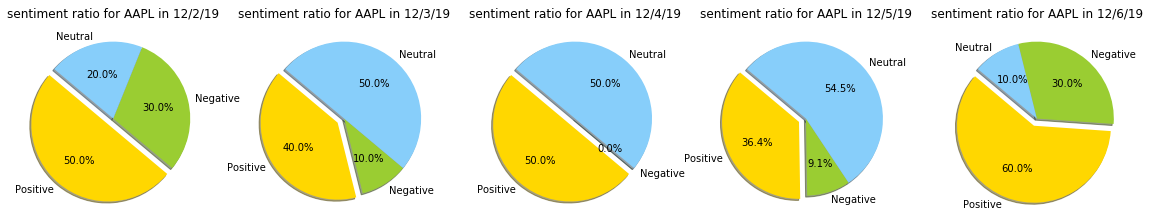

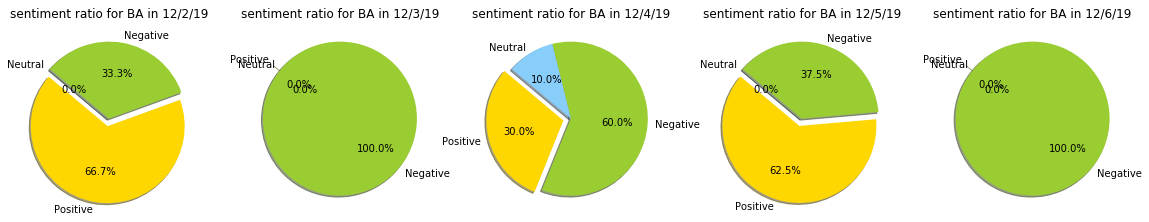

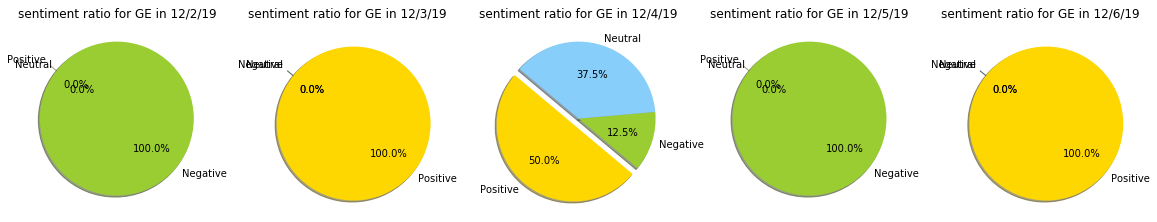

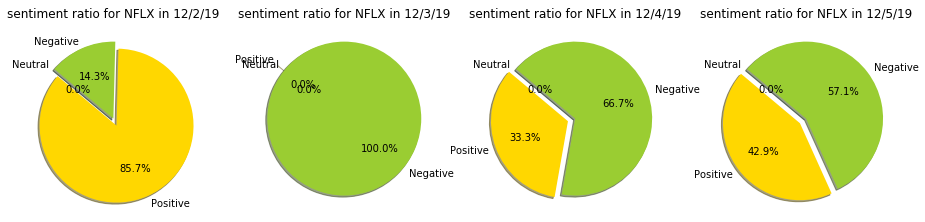

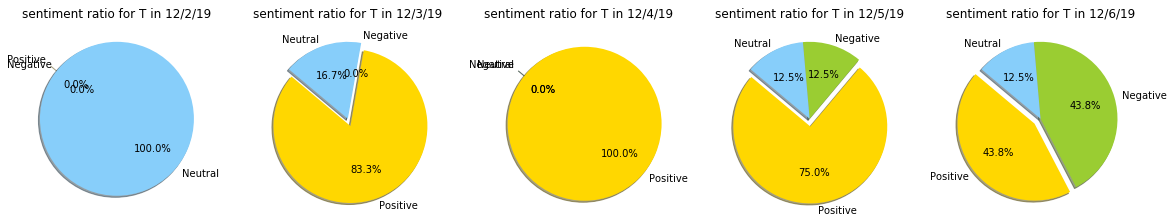

In [26]:
for ticker in con_dict:
    df=con_dict[ticker]
    plot_sentiment(df,ticker)

# Sentiment vs price and volume

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import datetime as dt
import urllib.request
import random
import arrow
import json

In [75]:
def cal_daily_sent(df_sent,start,end,ticker):
    start=datetime.datetime(2019,12,2)
    end=datetime.datetime(2019,12,6)

    df_sent.index=pd.to_datetime(df_sent.index)
    df_stock = pdr.DataReader(ticker, 'yahoo',start,end)
    df_stock['Sentiment']=0
    for date in df_stock.index:
        if date not in df_sent.index:
            continue

        if df_sent['sentiment'].loc[date].size>1:
            daily_sent=sum(df_sent['sentiment'].loc[date])/len(df_sent['sentiment'].loc[date])
        else:
            daily_sent=df_sent['sentiment'].loc[date]
        if daily_sent>0.33:
            df_stock['Sentiment'].loc[date]=1
        elif daily_sent<-0.33:
            df_stock['Sentiment'].loc[date]=-1
    return df_stock

In [81]:
start=datetime.datetime(2019,12,2)
end=datetime.datetime(2019,12,6)
stock_dict={}
for ticker in con_dict:
    df=con_dict[ticker]
    df_stock=cal_daily_sent(df,start,end,'AAPL')
    stock_dict[ticker]=df_stock

C:\Users\Administrator\Anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [93]:
df_aapl=stock_dict['AAPL']
df_aapl.head()

,High,Low,Open,Close,Volume,Adj Close,Sentiment
Date,,,,,,,
2019-12-02,268.250000,263.450012,267.269989,264.160004,23621800,264.160004,0
2019-12-03,259.529999,256.290009,258.309998,259.450012,28607600,259.450012,0
2019-12-04,263.309998,260.679993,261.070007,261.739990,16795400,261.739990,1
2019-12-05,265.890015,262.730011,263.790009,265.579987,18606100,265.579987,0
2019-12-06,271.000000,267.510010,267.480011,270.709991,26547493,270.709991,0


In [88]:
def sent_plot(df, ticker,item):
    plt.style.use('ggplot')
    colors = {-1:'red', 0:'blue', 1:'green'}
    days = [1, 2, 3, 4, 5]

    plt.scatter(days, df[item],s=50, c=df['Sentiment'].apply(lambda x: colors[x]), alpha=0.8, label='close', edgecolor='none')
    plt.ylabel(item)
    plt.xlabel('Days')
    plt.title(ticker+': Sentiment vs {}'.format(item))
    plt.show()

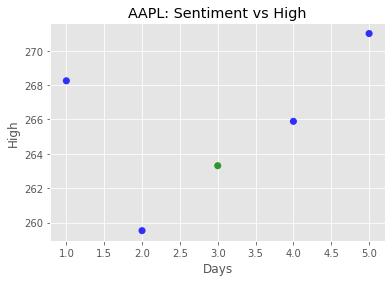

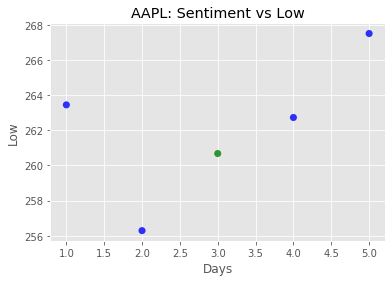

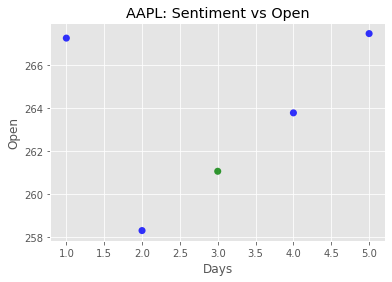

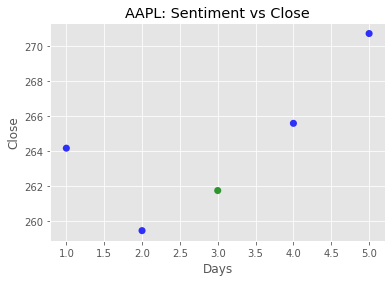

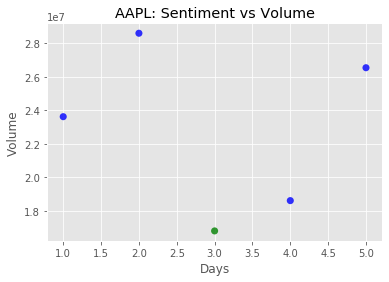

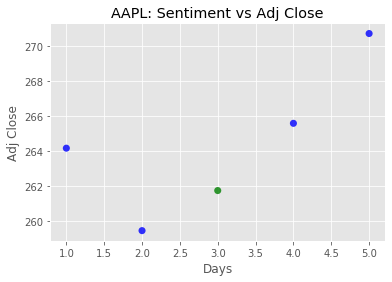

In [90]:
item_list=stock_dict['AAPL'].columns[:-1]
for ticker in stock_dict:
    if ticker=='AAPL':
        for item in item_list:
            sent_plot(stock_dict[ticker],ticker,item)

# Sentiment vs Volatility

We used intraday price to calculate daily volatility.

In [91]:
# use proxies as scraper
def url_openproxy(url):
    req=urllib.request.Request(url)
    req.add_header('User-Agent', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36')
    
    proxies=['119.6.144.70:81','111.1.36.9:80','203.144.144.162:8080']
    proxy=random.choice(proxies)
    proxy_sup=urllib.request.ProxyHandler({'http':proxy})
    opener=urllib.request.build_opener(proxy_sup)
    urllib.request.install_opener(opener)
    
    response=urllib.request.urlopen(url)
    html=response.read()
   
    return html 

# retrieving high frequency data
def get_quote_data(symbol='SBIN.NS', data_range='1d', data_interval='1m'):
    res = url_openproxy('https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?range={data_range}&interval={data_interval}'.format(**locals()))
    data = json.loads(res.decode('utf-8'))
    body = data['chart']['result'][0]    
    dt = pd.Series(map(lambda x: arrow.get(x).to('EST').datetime.replace(tzinfo=None), body['timestamp']), name='Datetime')
    df = pd.DataFrame(body['indicators']['quote'][0], index=dt)
    dg = pd.DataFrame(body['timestamp'])    
    df = df.loc[:, ('open', 'high', 'low', 'close', 'volume')]
    df.dropna(inplace=True)     #removing NaN rows
    df.columns = ['OPEN', 'HIGH','LOW','CLOSE','VOLUME']    #Renaming columns in pandas
    
    return df

In [107]:
# obtain S&P500 30-minute price and volume in recent 5 days
interday_df =get_quote_data('AAPL', '5d', '30m')
interday_df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME
Datetime,,,,,
2019-12-02 09:30:00,267.269989,268.100006,266.549988,266.559998,3837545
2019-12-02 10:00:00,266.570007,266.584991,264.829987,265.449707,2305994
2019-12-02 10:30:00,265.445007,265.510010,263.745911,263.745911,2149730
2019-12-02 11:00:00,263.790009,264.500000,263.556610,264.269989,3019776
2019-12-02 11:30:00,264.260010,264.890015,263.974609,264.676208,1035600


In [113]:
# calculate intraday volatility
def cal_vol(df,ticker):
    interday_df =get_quote_data(ticker, '5d', '30m')
    vols = []
    dates=df.index
    for date in dates:
        vol = float(interday_df.loc[interday_df.index.date == date][['CLOSE']].std())
        vols.append(vol)
    df['Vol'] = vols

In [121]:
for ticker in con_dict:
    df=stock_dict[ticker]
    cal_vol(df,ticker)
    
stock_dict['AAPL']

,High,Low,Open,Close,Volume,Adj Close,Sentiment,Vol
Date,,,,,,,,
2019-12-02,268.250000,263.450012,267.269989,264.160004,23621800,264.160004,0,0.779368
2019-12-03,259.529999,256.290009,258.309998,259.450012,28607600,259.450012,0,0.736689
2019-12-04,263.309998,260.679993,261.070007,261.739990,16795400,261.739990,1,0.515320
2019-12-05,265.890015,262.730011,263.790009,265.579987,18606100,265.579987,0,0.699604
2019-12-06,271.000000,267.510010,267.480011,270.709991,26547493,270.709991,0,0.624085


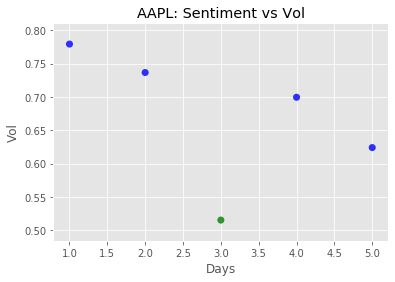

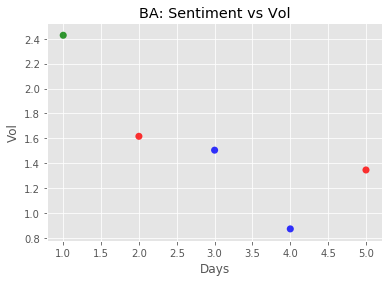

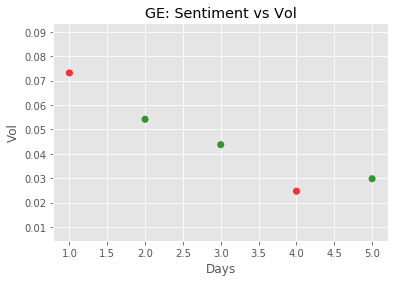

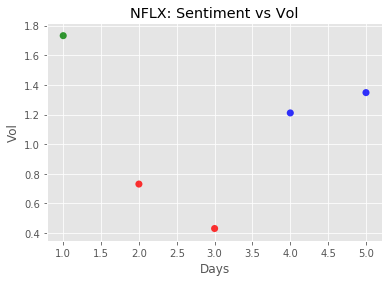

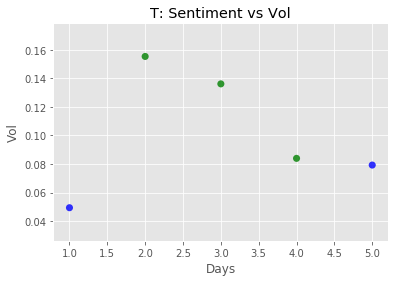

In [122]:
for ticker in stock_dict:
    sent_plot(stock_dict[ticker],ticker,'Vol')

# Correlation between Sentiment and Price,Volume,Volatility

In [132]:
for ticker in stock_dict:
    print('Correlation for '+ticker+':\n', stock_dict[ticker].corr()['Sentiment'], '\n')

Correlation for AAPL:
 High        -0.288734
Low         -0.197954
Open        -0.354279
Close       -0.339079
Volume      -0.668392
Adj Close   -0.339079
Sentiment    1.000000
Vol         -0.836392
Name: Sentiment, dtype: float64 

Correlation for BA:
 High         0.223873
Low          0.129857
Open         0.381451
Close       -0.117095
Volume      -0.514447
Adj Close   -0.117095
Sentiment    1.000000
Vol          0.538930
Name: Sentiment, dtype: float64 

Correlation for GE:
 High        -0.304021
Low         -0.213277
Open        -0.447824
Close       -0.115963
Volume       0.311117
Adj Close   -0.115963
Sentiment    1.000000
Vol         -0.178091
Name: Sentiment, dtype: float64 

Correlation for NFLX:
 High         0.743046
Low          0.627572
Open         0.864293
Close        0.511099
Volume       0.062370
Adj Close    0.511099
Sentiment    1.000000
Vol          0.965533
Name: Sentiment, dtype: float64 

Correlation for T:
 High        -0.831001
Low         -0.745355
Open    

As we can see above, most stocks have large positive correlation between sentiment values and intraday volatility.  

# Other Analysis

In [136]:
for ticker in stock_dict:
    stock_dict[ticker].to_csv('data\\'+ticker+'_price_sentiment.csv')